In [77]:
import numpy as np
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
import sys,os
from matplotlib import pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='6' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='6' # set number of MKL threads to run in parallel
os.environ['MKL_DEBUG_CPU_TYPE'] = '5'
import scienceplots
plt.style.use(['science','ieee'])
plt.rcParams['text.usetex'] = True
from scipy.stats import gaussian_kde
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

In [2]:
## Model parameters
L = 16
Ja=-9.3 # /2 Pi 
Je=-6.1
jx = np.random.normal(size = L-3)*np.pi
Omega=3*np.pi
J_nn = 0.3
basis = spin_basis_1d(L,Nup=int(L/2), pauli = 0)
i_0 = basis.index('1001100110011001')

In [3]:
basis[0]

65280

In [4]:
ja_hop_pm,je_hop_pm,ja_hop_mp,je_hop_mp,omega,j_nn = [],[],[],[],[],[]
for i in range(L-1):
    if i%2 == 0:
        ja_hop_pm+=[[Ja,i,(i+1)]]
        ja_hop_mp+=[[Ja,i,(i+1)]]
    else:
        je_hop_pm+=[[Je,i,(i+1)]]
        je_hop_mp+=[[Je,i,(i+1)]]
#Staircase potential
for n in range(int(L/2)):
    site = 2*n
    omega_val =0.8*n
    omega += [[omega_val,site,site],[omega_val,site-1,site-1]]
    
# next-next-nearest
for i in range(L-3):
    j_nn += [[J_nn,i,i+3]]
#for i in range(L-3):
    #jx_nn += [[jx[i]/2,i,i+2]]

In [5]:
static = [['+-',ja_hop_pm],['-+',ja_hop_mp],['+-',je_hop_pm],['-+',je_hop_mp],['+-',omega],['+-',j_nn],['-+',j_nn]]
dynamic = []

In [6]:
j_nn

[[0.3, 0, 3],
 [0.3, 1, 4],
 [0.3, 2, 5],
 [0.3, 3, 6],
 [0.3, 4, 7],
 [0.3, 5, 8],
 [0.3, 6, 9],
 [0.3, 7, 10],
 [0.3, 8, 11],
 [0.3, 9, 12],
 [0.3, 10, 13],
 [0.3, 11, 14],
 [0.3, 12, 15]]

In [7]:
H= hamiltonian(static,dynamic, basis=basis)

Hermiticity check passed!
Particle conservation check passed!


C:\Users\Charlie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  """Entry point for launching an IPython kernel.


In [8]:
eigenvalues,eigenvectors = H.eigh()

In [9]:
psi_0 = np.zeros(basis.Ns)
psi_0_thermal = np.zeros(basis.Ns)
psi_0[i_0]=1
psi_0_thermal[600]=1
times = np.linspace(0,5,1000)

In [10]:
psi_t = H.evolve(psi_0,times.min(),times)
psi_t_thermal = H.evolve(psi_0_thermal,times.min(),times)

In [11]:
entropies = []
pa_t = []
thermal_entropies = []
for i in range(len(times)):
    entropies.append(basis.ent_entropy(psi_t[:,i],sub_sys_A = [0,1,2,3])['Sent_A'])
    thermal_entropies.append(basis.ent_entropy(psi_t_thermal[:,i],sub_sys_A = [0,1,2,3])['Sent_A'])
    pa_t.append(basis.partial_trace(psi_t[:,i],[0,1,2,3]))

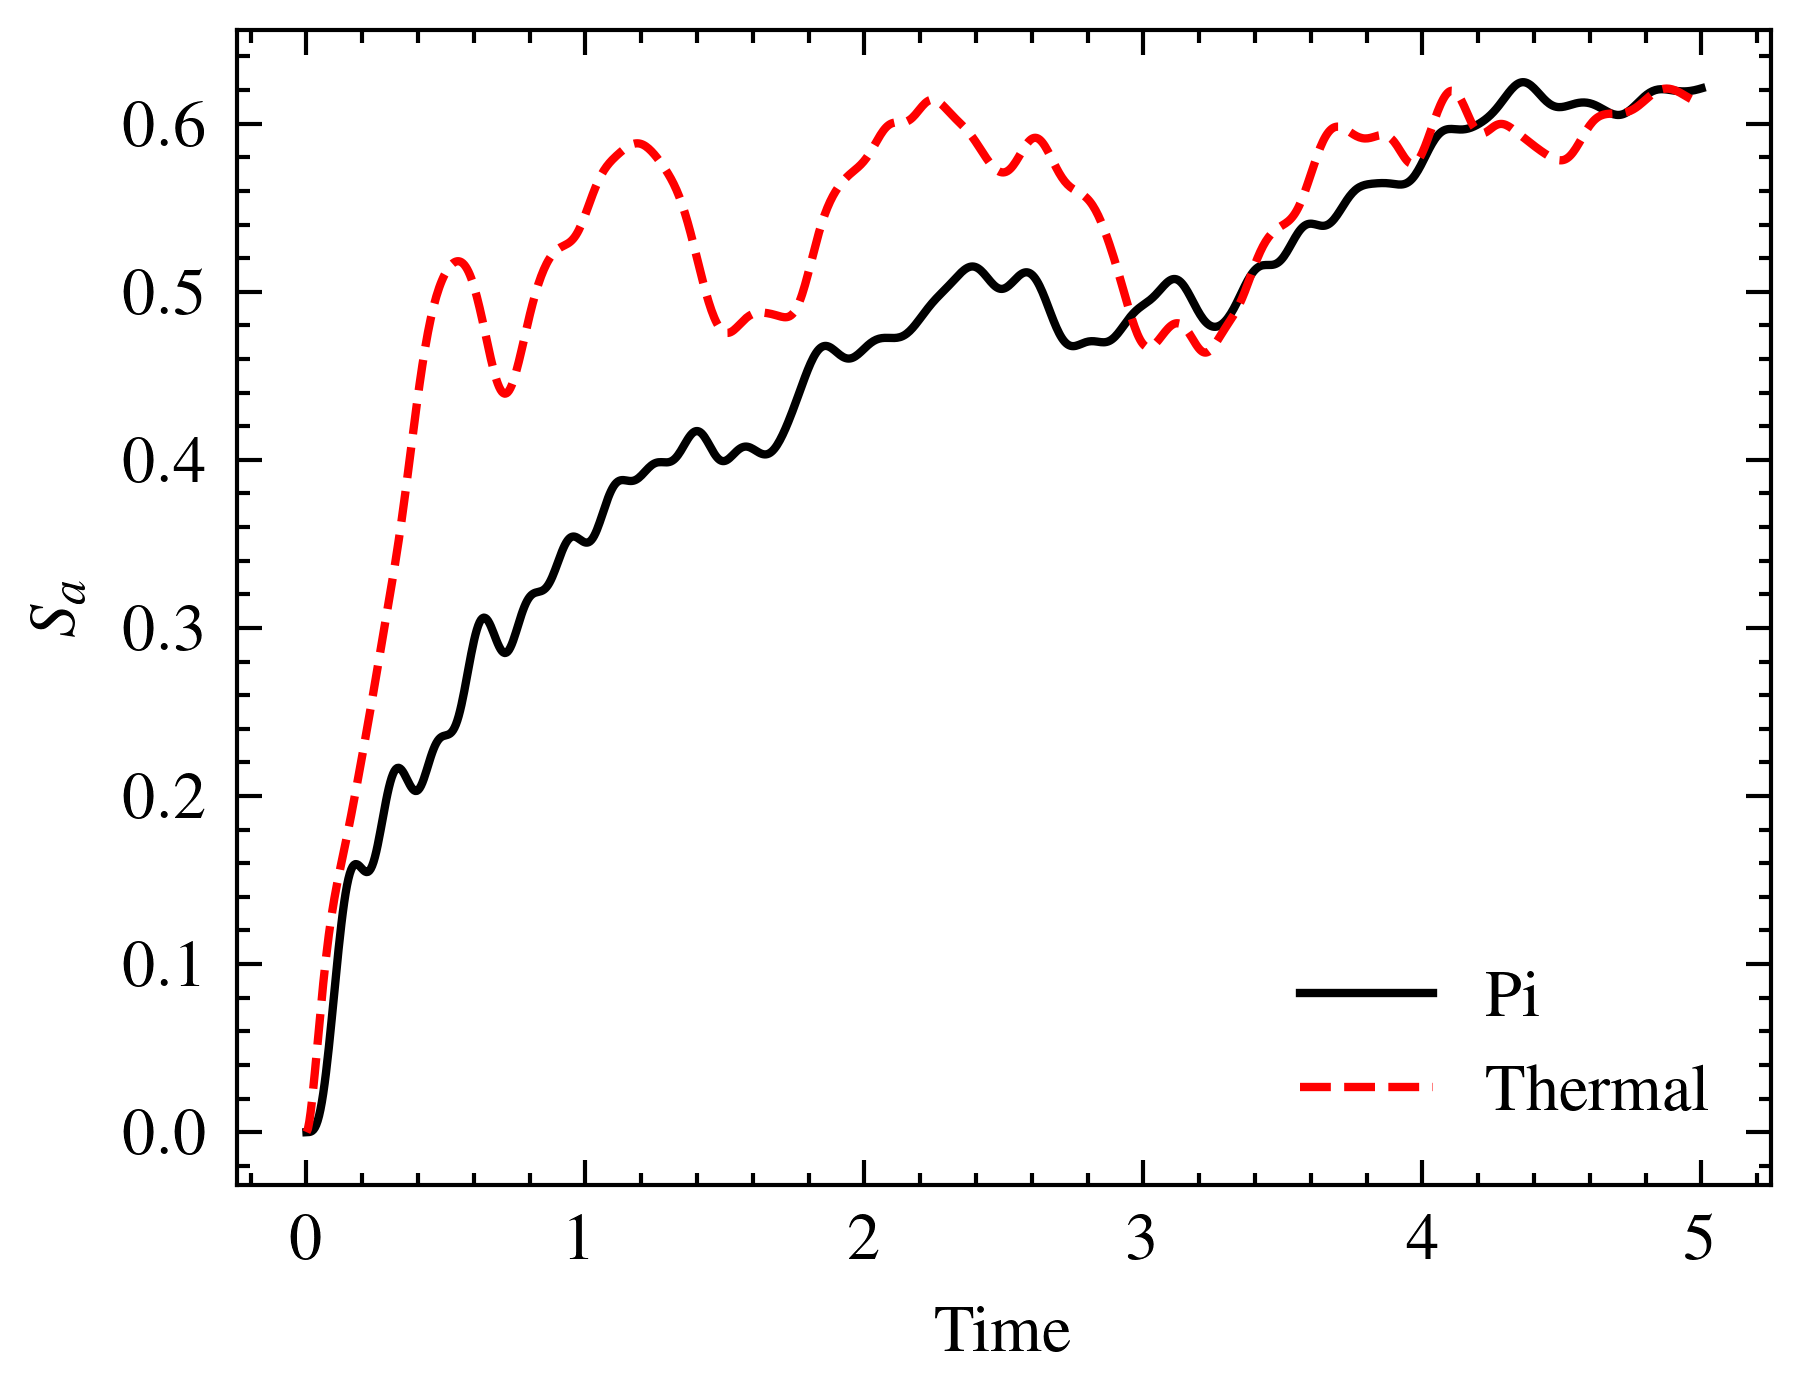

In [12]:
plt.plot(times,entropies,label = 'Pi')
plt.plot(times,thermal_entropies,label = 'Thermal')
plt.xlabel('Time')
plt.ylabel(r'$S_a$')
plt.legend()

In [13]:
#Dynamics of Fidelity
timefidels = []
thermfidels =[]
for i in range(len(times)):
    timefidels.append(np.abs(np.vdot(psi_0,psi_t[:,i])**2))
    thermfidels.append(np.abs(np.vdot(psi_0_thermal,psi_t_thermal[:,i])**2))

Text(0, 0.5, 'Fidelity')

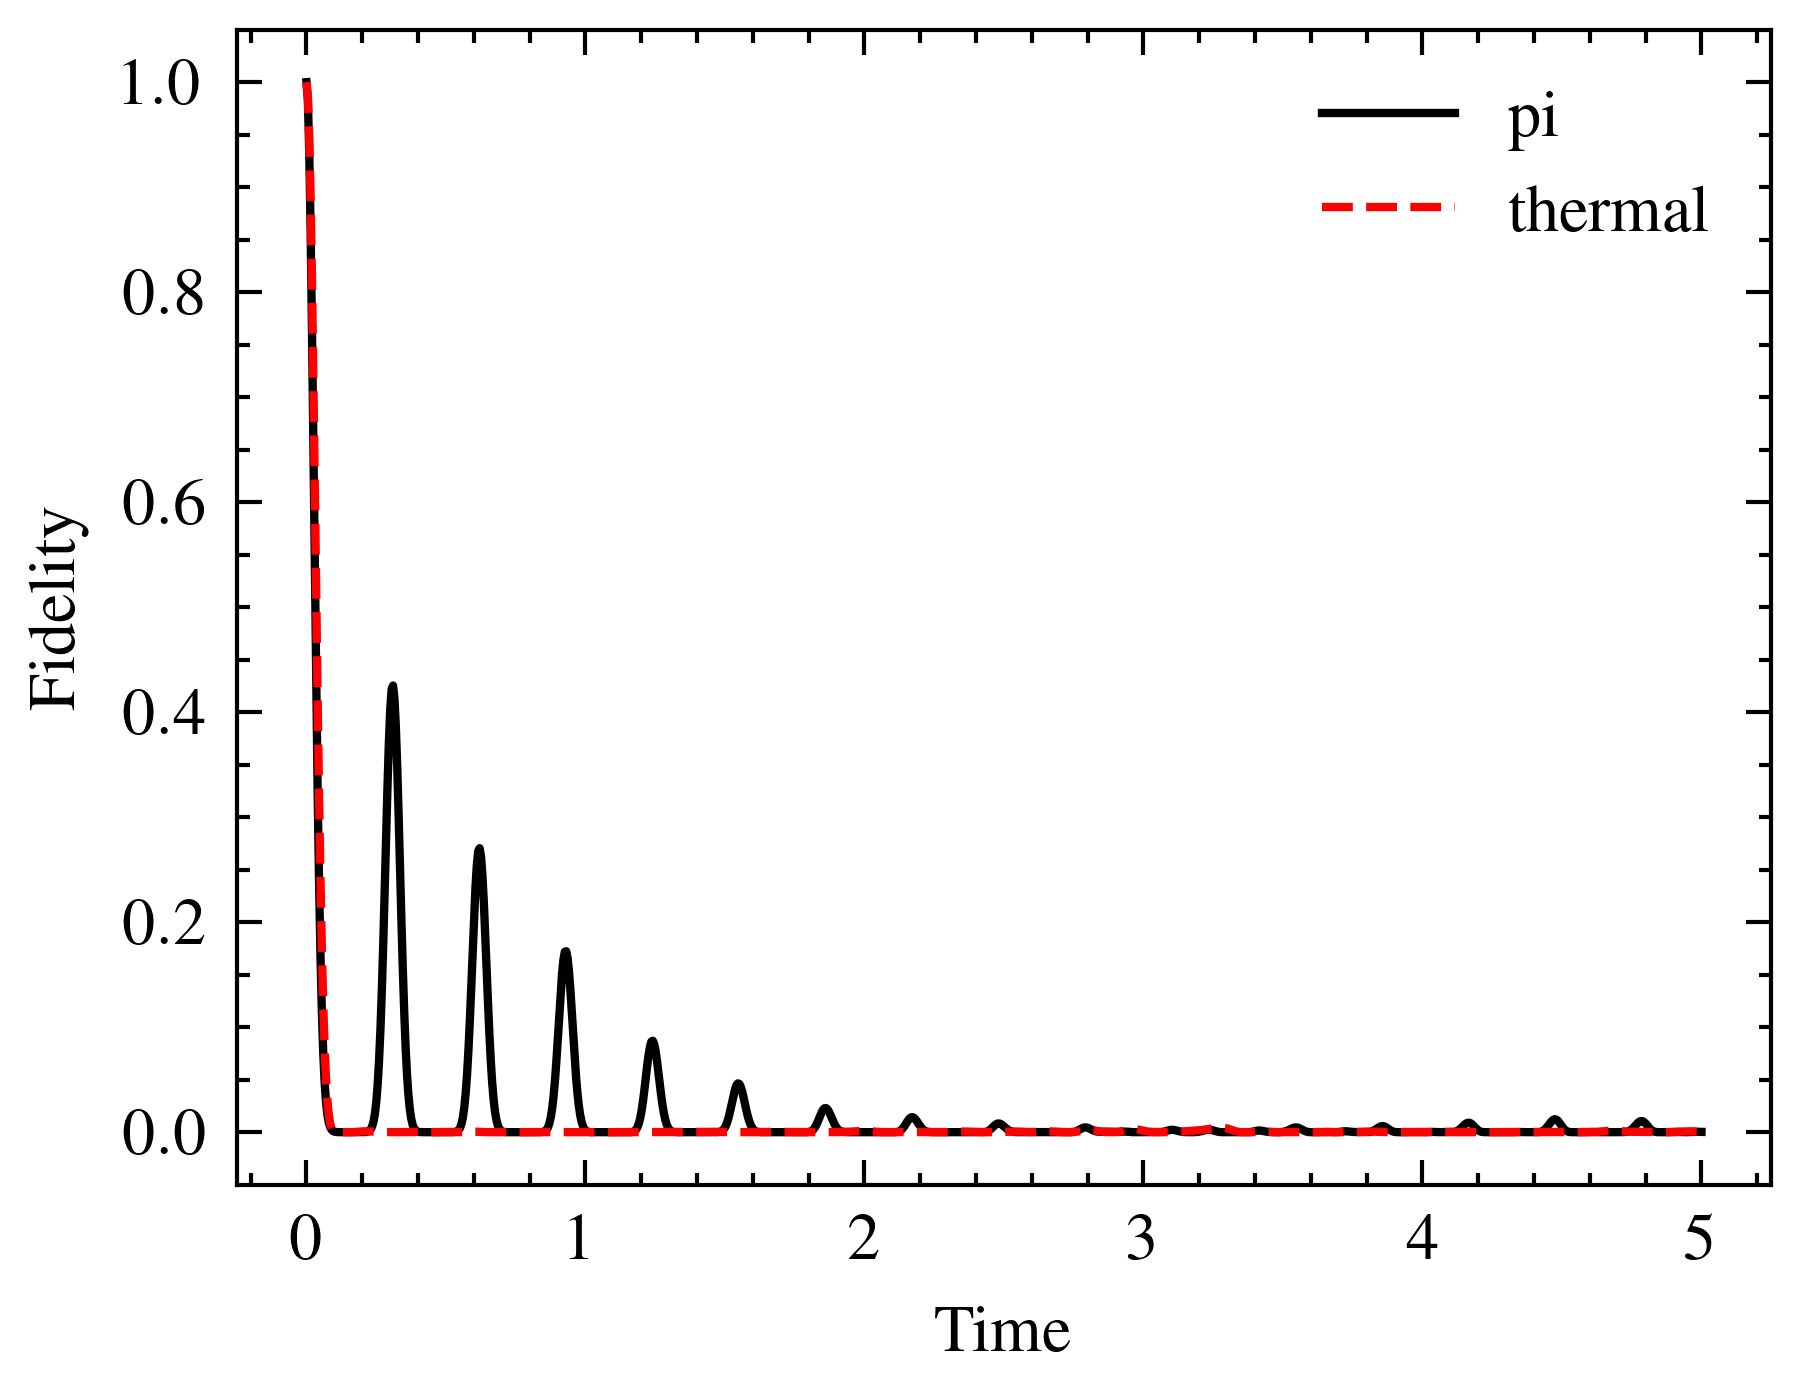

In [14]:
plt.plot(times,timefidels,label='pi')
plt.plot(times,thermfidels,label='thermal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Fidelity')

In [58]:
fidelsoverlap = []
for i in range(len(eigenvectors)):
    fidelsoverlap.append(np.abs(np.vdot(psi_0,eigenvectors[:,i])**2)/L)
    

In [57]:
eigenvalues
fidelsoverlap

[]

In [110]:
eigenvalues[39]

-38.09613409857249

In [111]:
fidelsoverlap[39]

0.00036569541737294884

C:\Users\Charlie\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Attempting to set identical bottom == top == 0.0001 results in singular transformations; automatically expanding.
  """


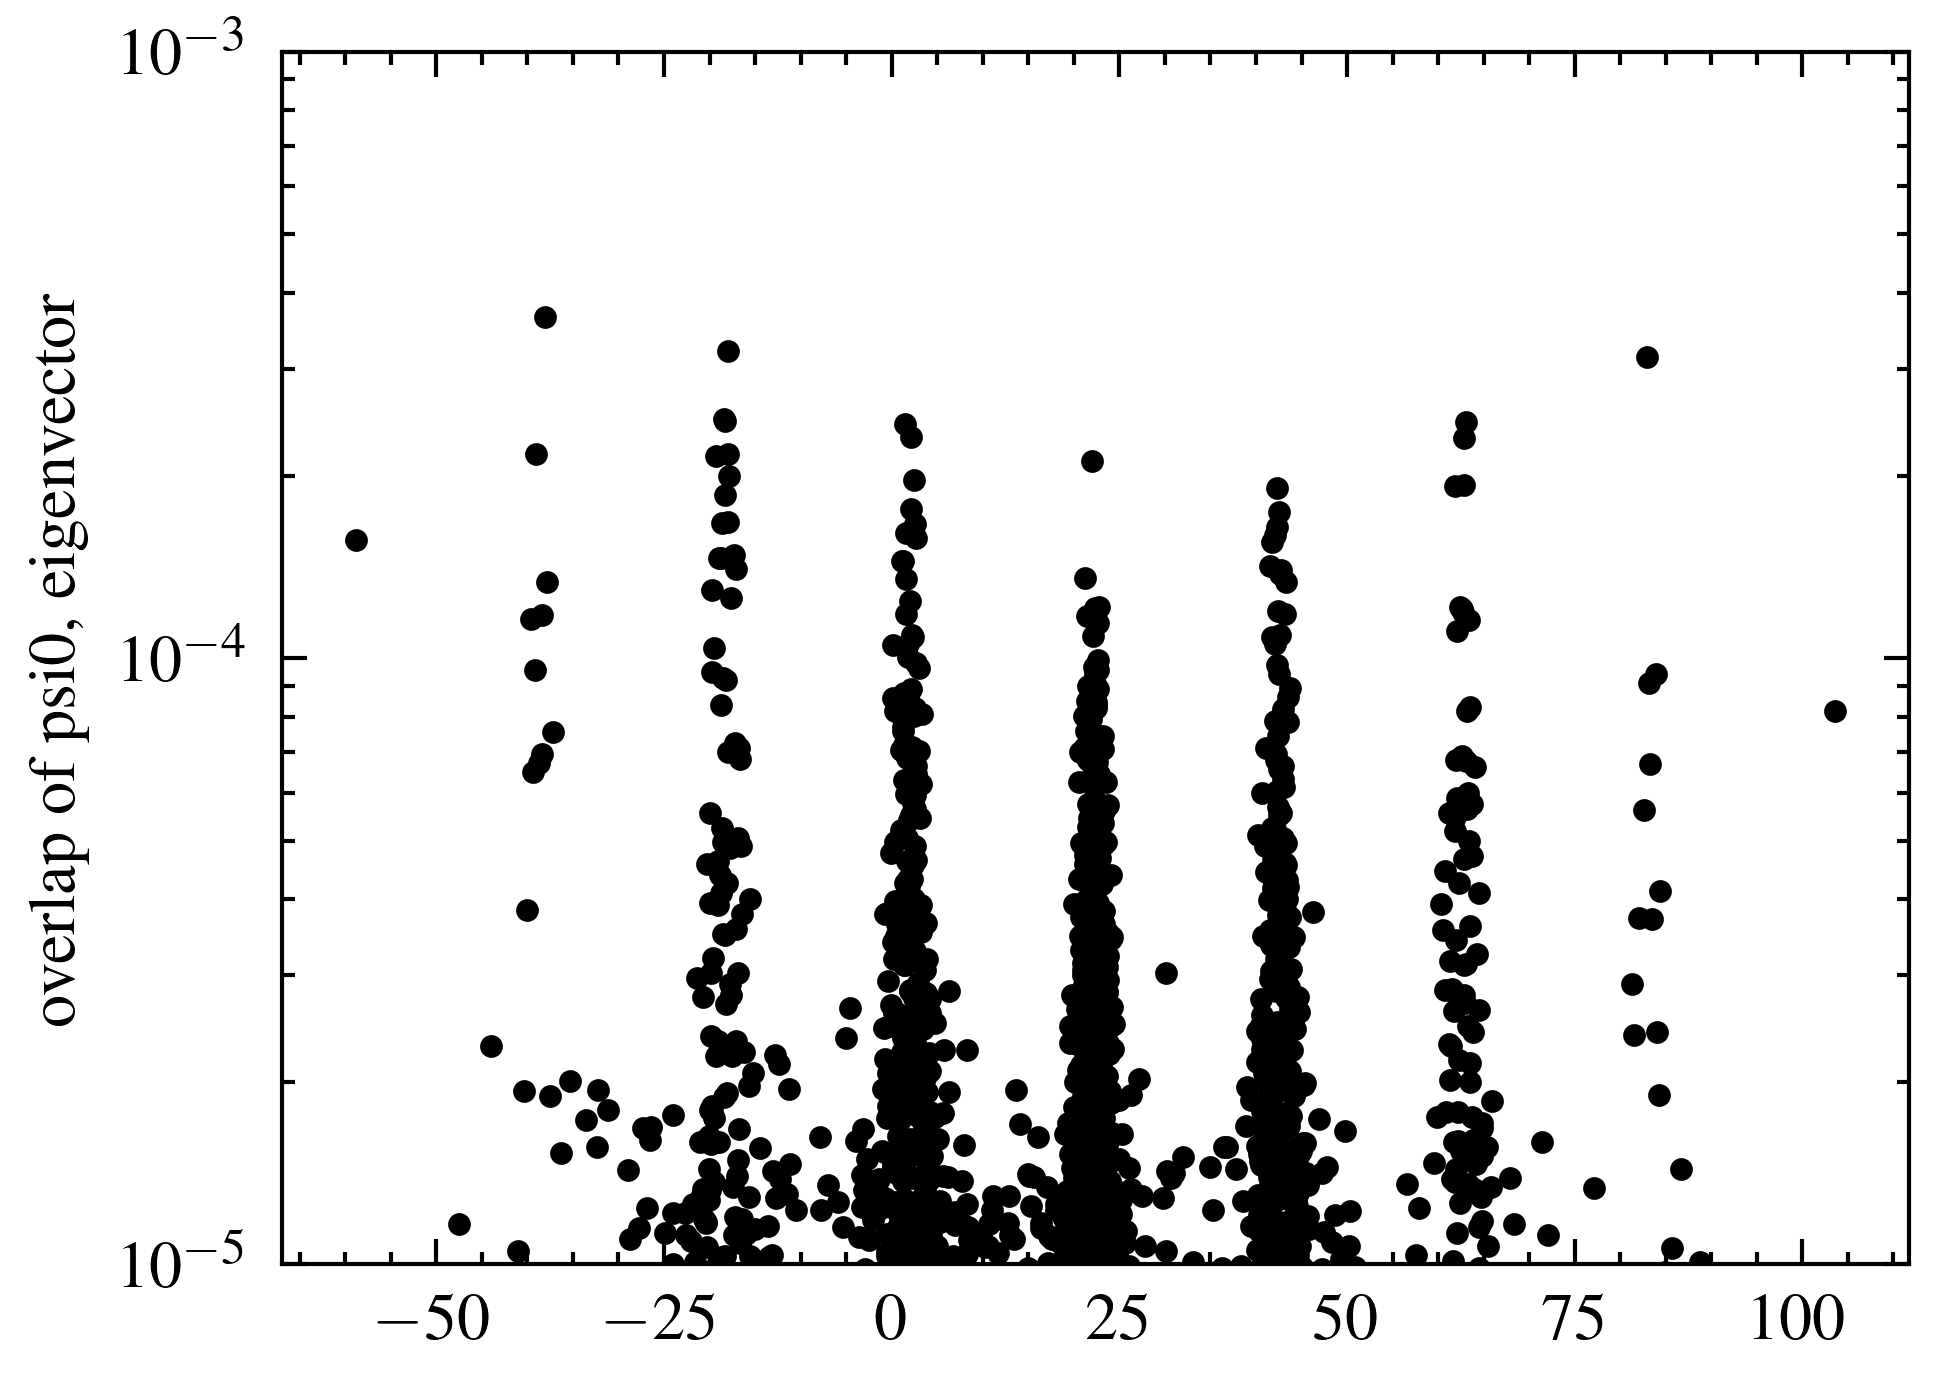

<Figure size 2100x1575 with 0 Axes>

In [114]:
with plt.style.context(['science', 'scatter']):
    plt.scatter(eigenvalues,fidelsoverlap,s=3,c='black')
    plt.yscale('log')
    plt.ylabel('overlap of psi0, eigenvector')
    plt.ylim(bottom = 10**-4,top = 0.0001)
    #plt.xlim(left =-40,right = -35)
    fig=plt.figure()

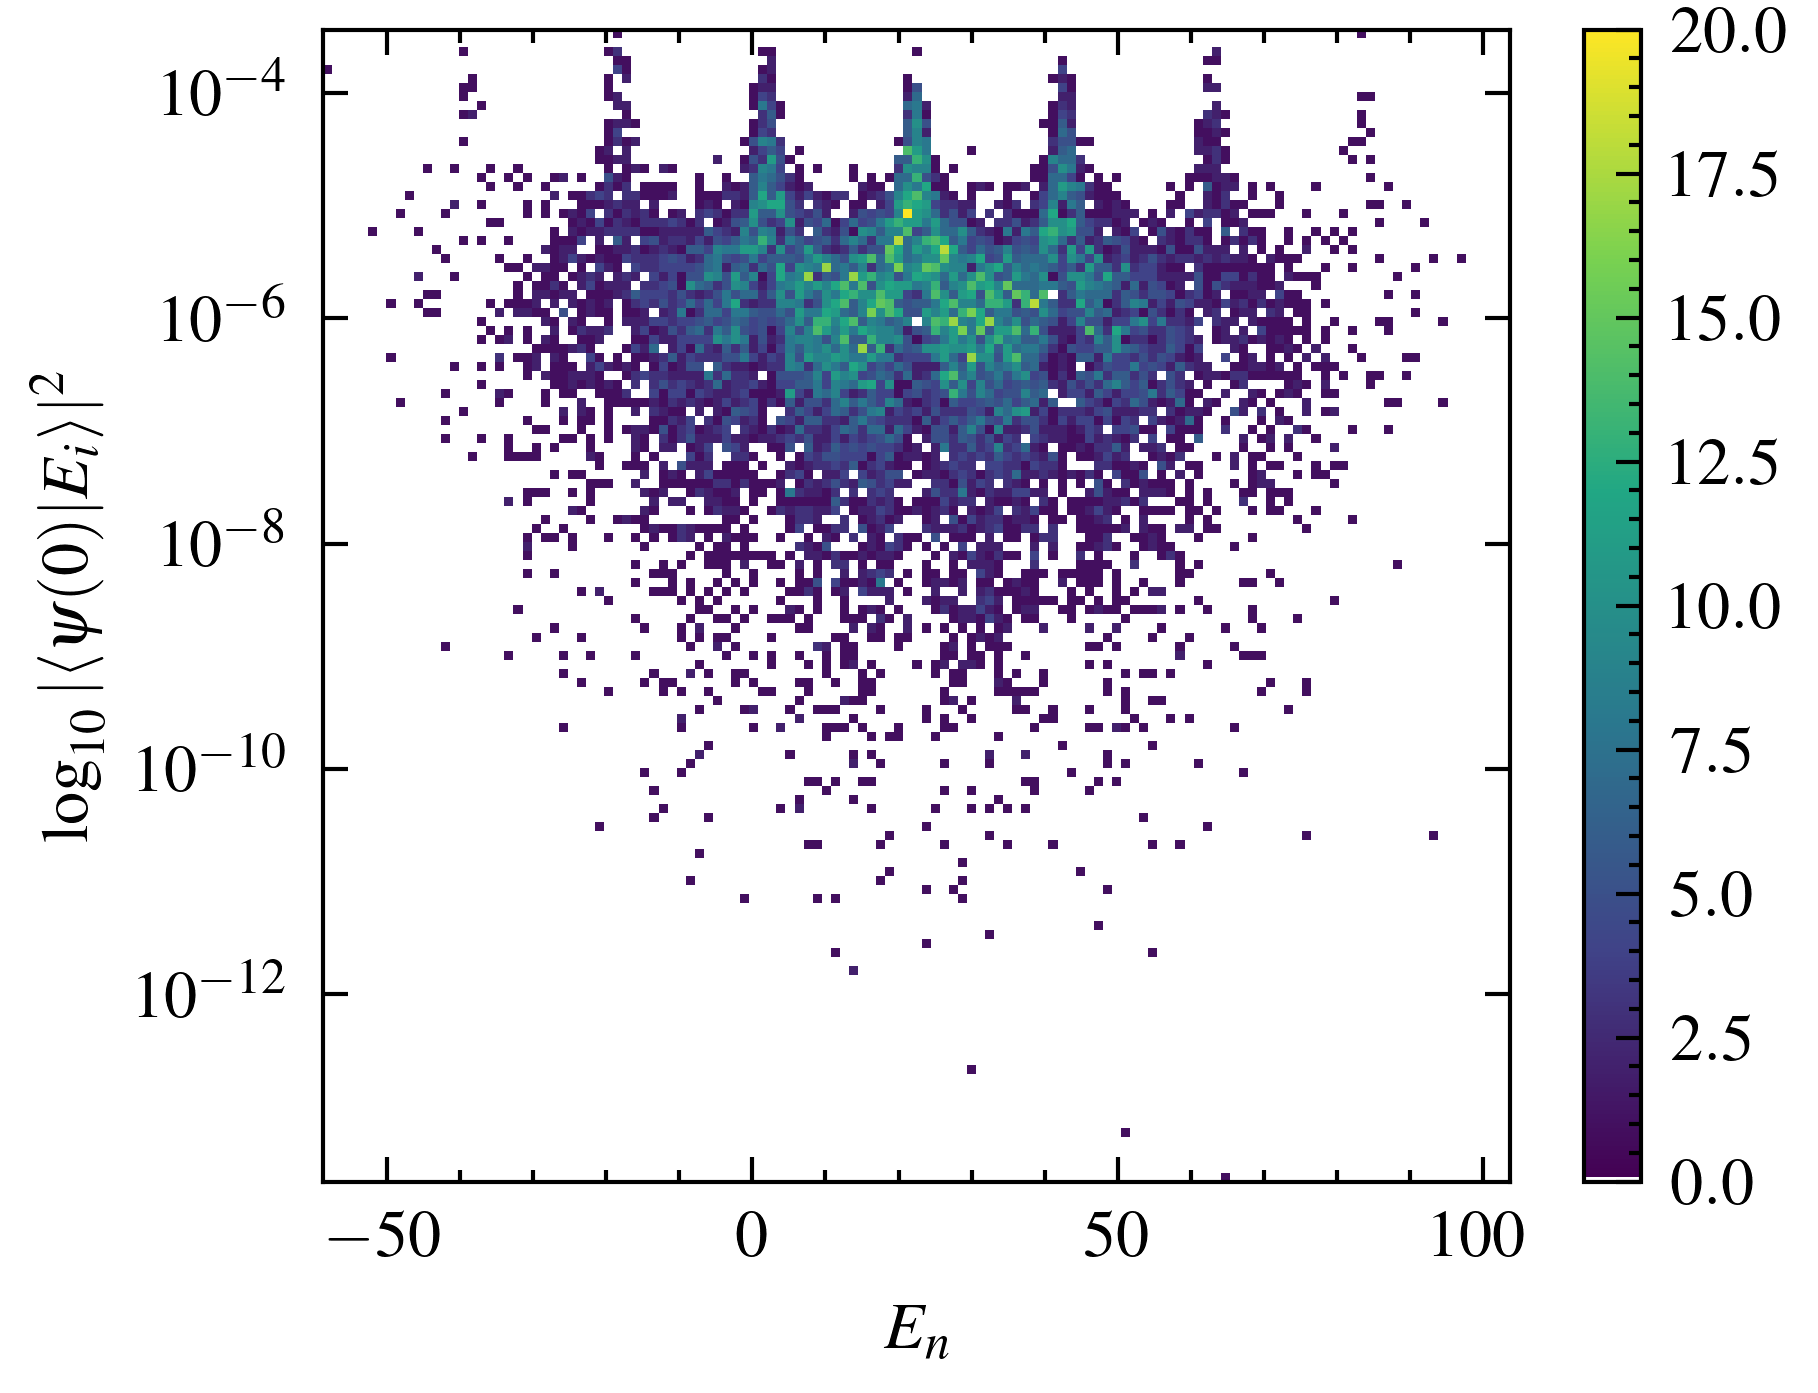

In [88]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(eigenvalues, fidelsoverlap, cmap=white_viridis)
    fig.colorbar(density)

fig = plt.figure()
using_mpl_scatter_density(fig, eigenvalues, fidelsoverlap)
plt.yscale('log')

plt.ylabel(r'$\log_{10}|\langle\psi(0)|E_i\rangle|^2$')
plt.xlabel(r'$E_n$')
plt.tight_layout()
plt.show()

In [45]:
spacing = []
for i in range(int(0.25*len(eigenvalues)),int(0.75*len(eigenvalues))):
    space = eigenvalues[i+1] - eigenvalues[i]
    #if space != 0:
    spacing.append(space)
S_i = spacing/np.mean(spacing)
Poisson=[]
Wigner_Dyson = []
for i in np.linspace(0,S_i.max()):
    Poisson.append(np.exp(-1*i))
    Wigner_Dyson.append((i*np.pi/2)*np.exp((-np.pi/4)*(i**2)))


In [26]:
S_i

array([1.66792673, 1.28248698, 1.177084  , ..., 1.177084  , 1.28248698,
       1.66792673])

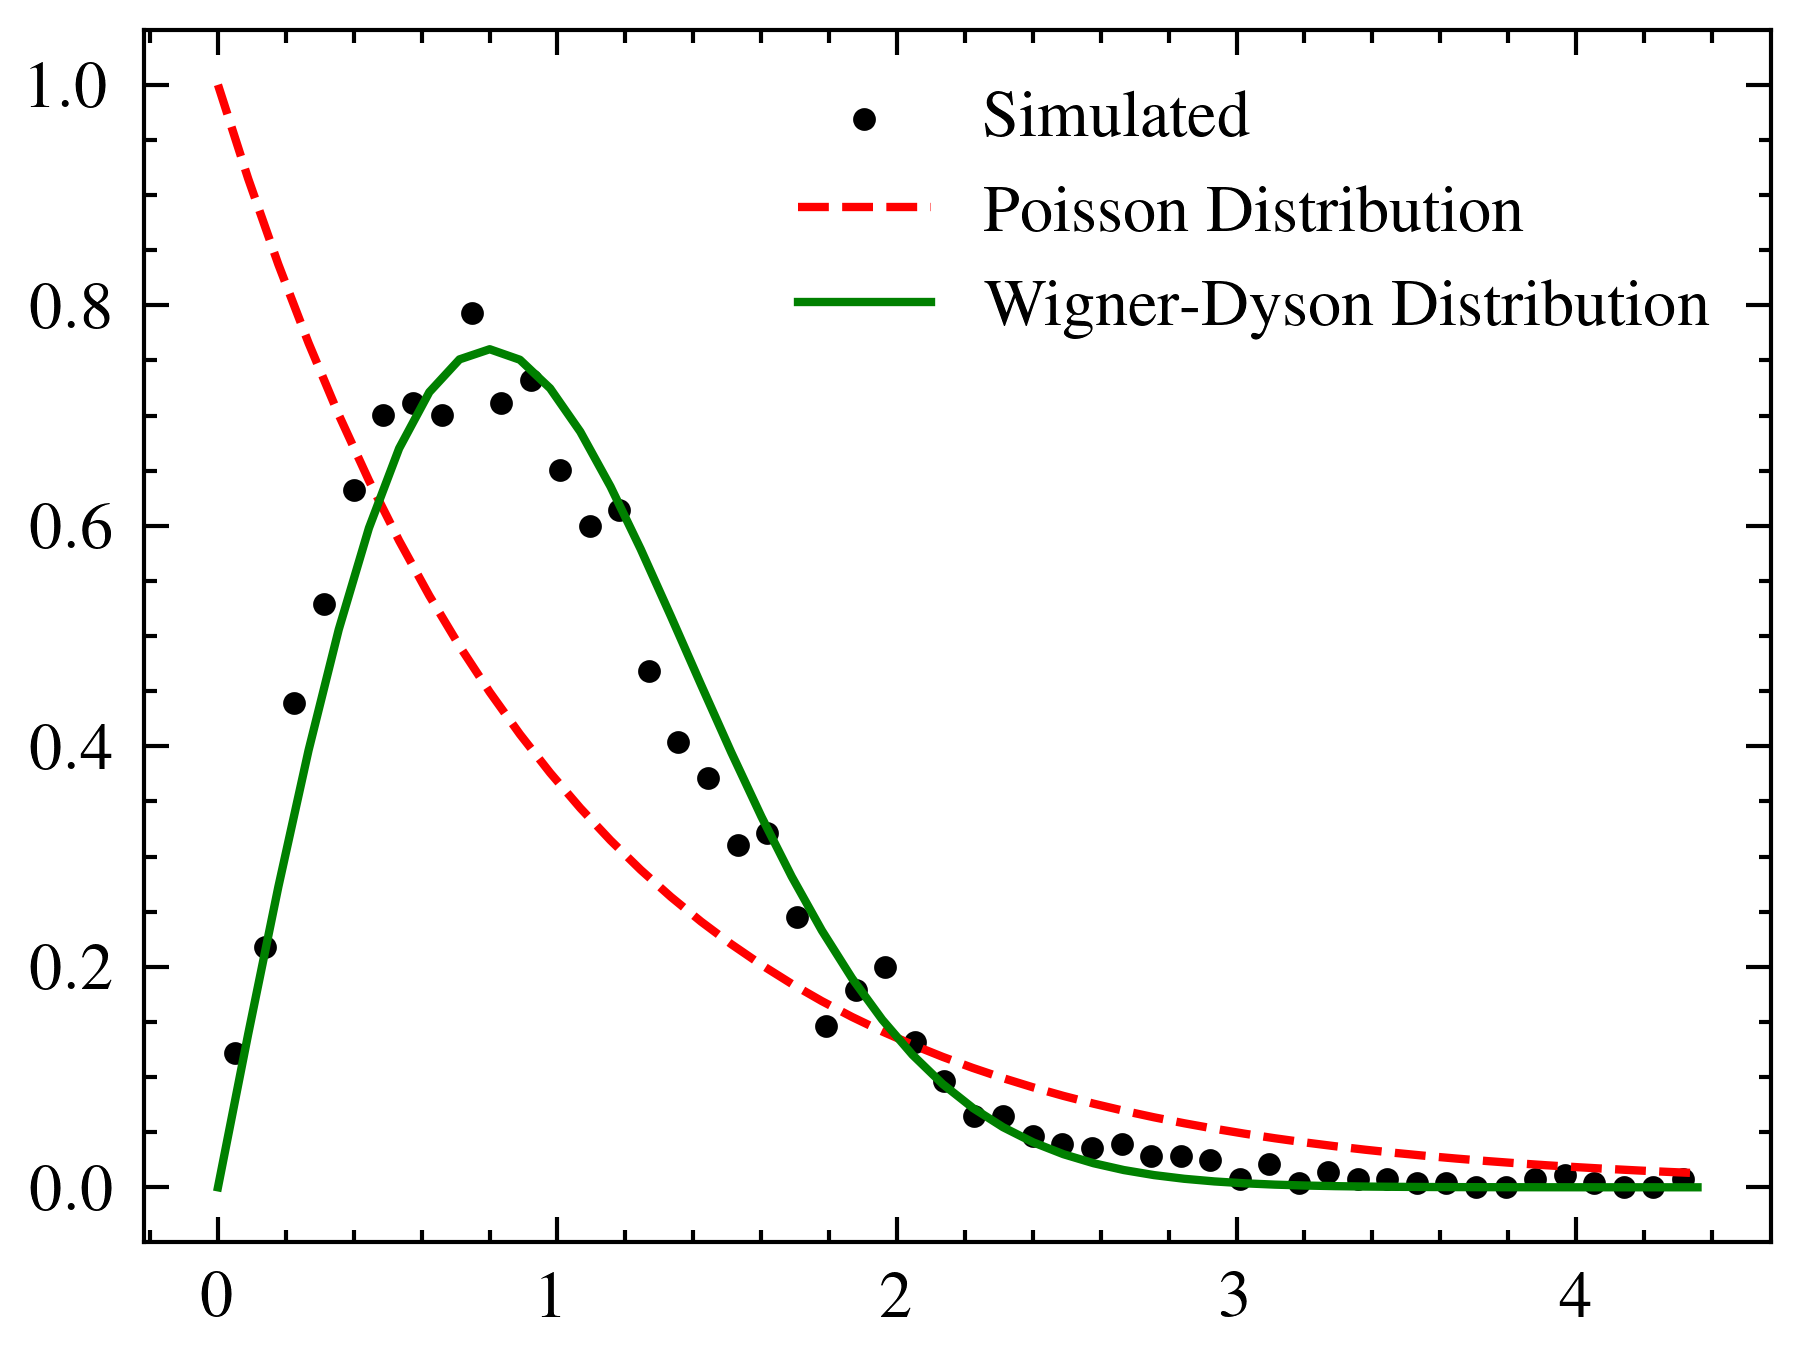

In [46]:
with plt.style.context(['science']):
    P_s,bins= np.histogram(S_i,density=True,bins=50)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(P_s))]
    plt.scatter(bins_mean,P_s,label = 'Simulated',s=3,color='black')
    plt.plot(np.linspace(0,S_i.max()),Poisson,color='red',label = 'Poisson Distribution',ls='--')
    plt.plot(np.linspace(0,S_i.max()),Wigner_Dyson,color='green',label = 'Wigner-Dyson Distribution')
    plt.legend()

In [116]:
from scipy import stats

chisq, p = chisquare(P_s,Wigner_Dyson)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.023295613876309525

In [25]:
eigen_entropies = []
for i in range(len(eigenvalues)):
    eigen_entropies.append(basis.ent_entropy(eigenvectors[:,i],sub_sys_A = [0,1,2,3])['Sent_A']/L)

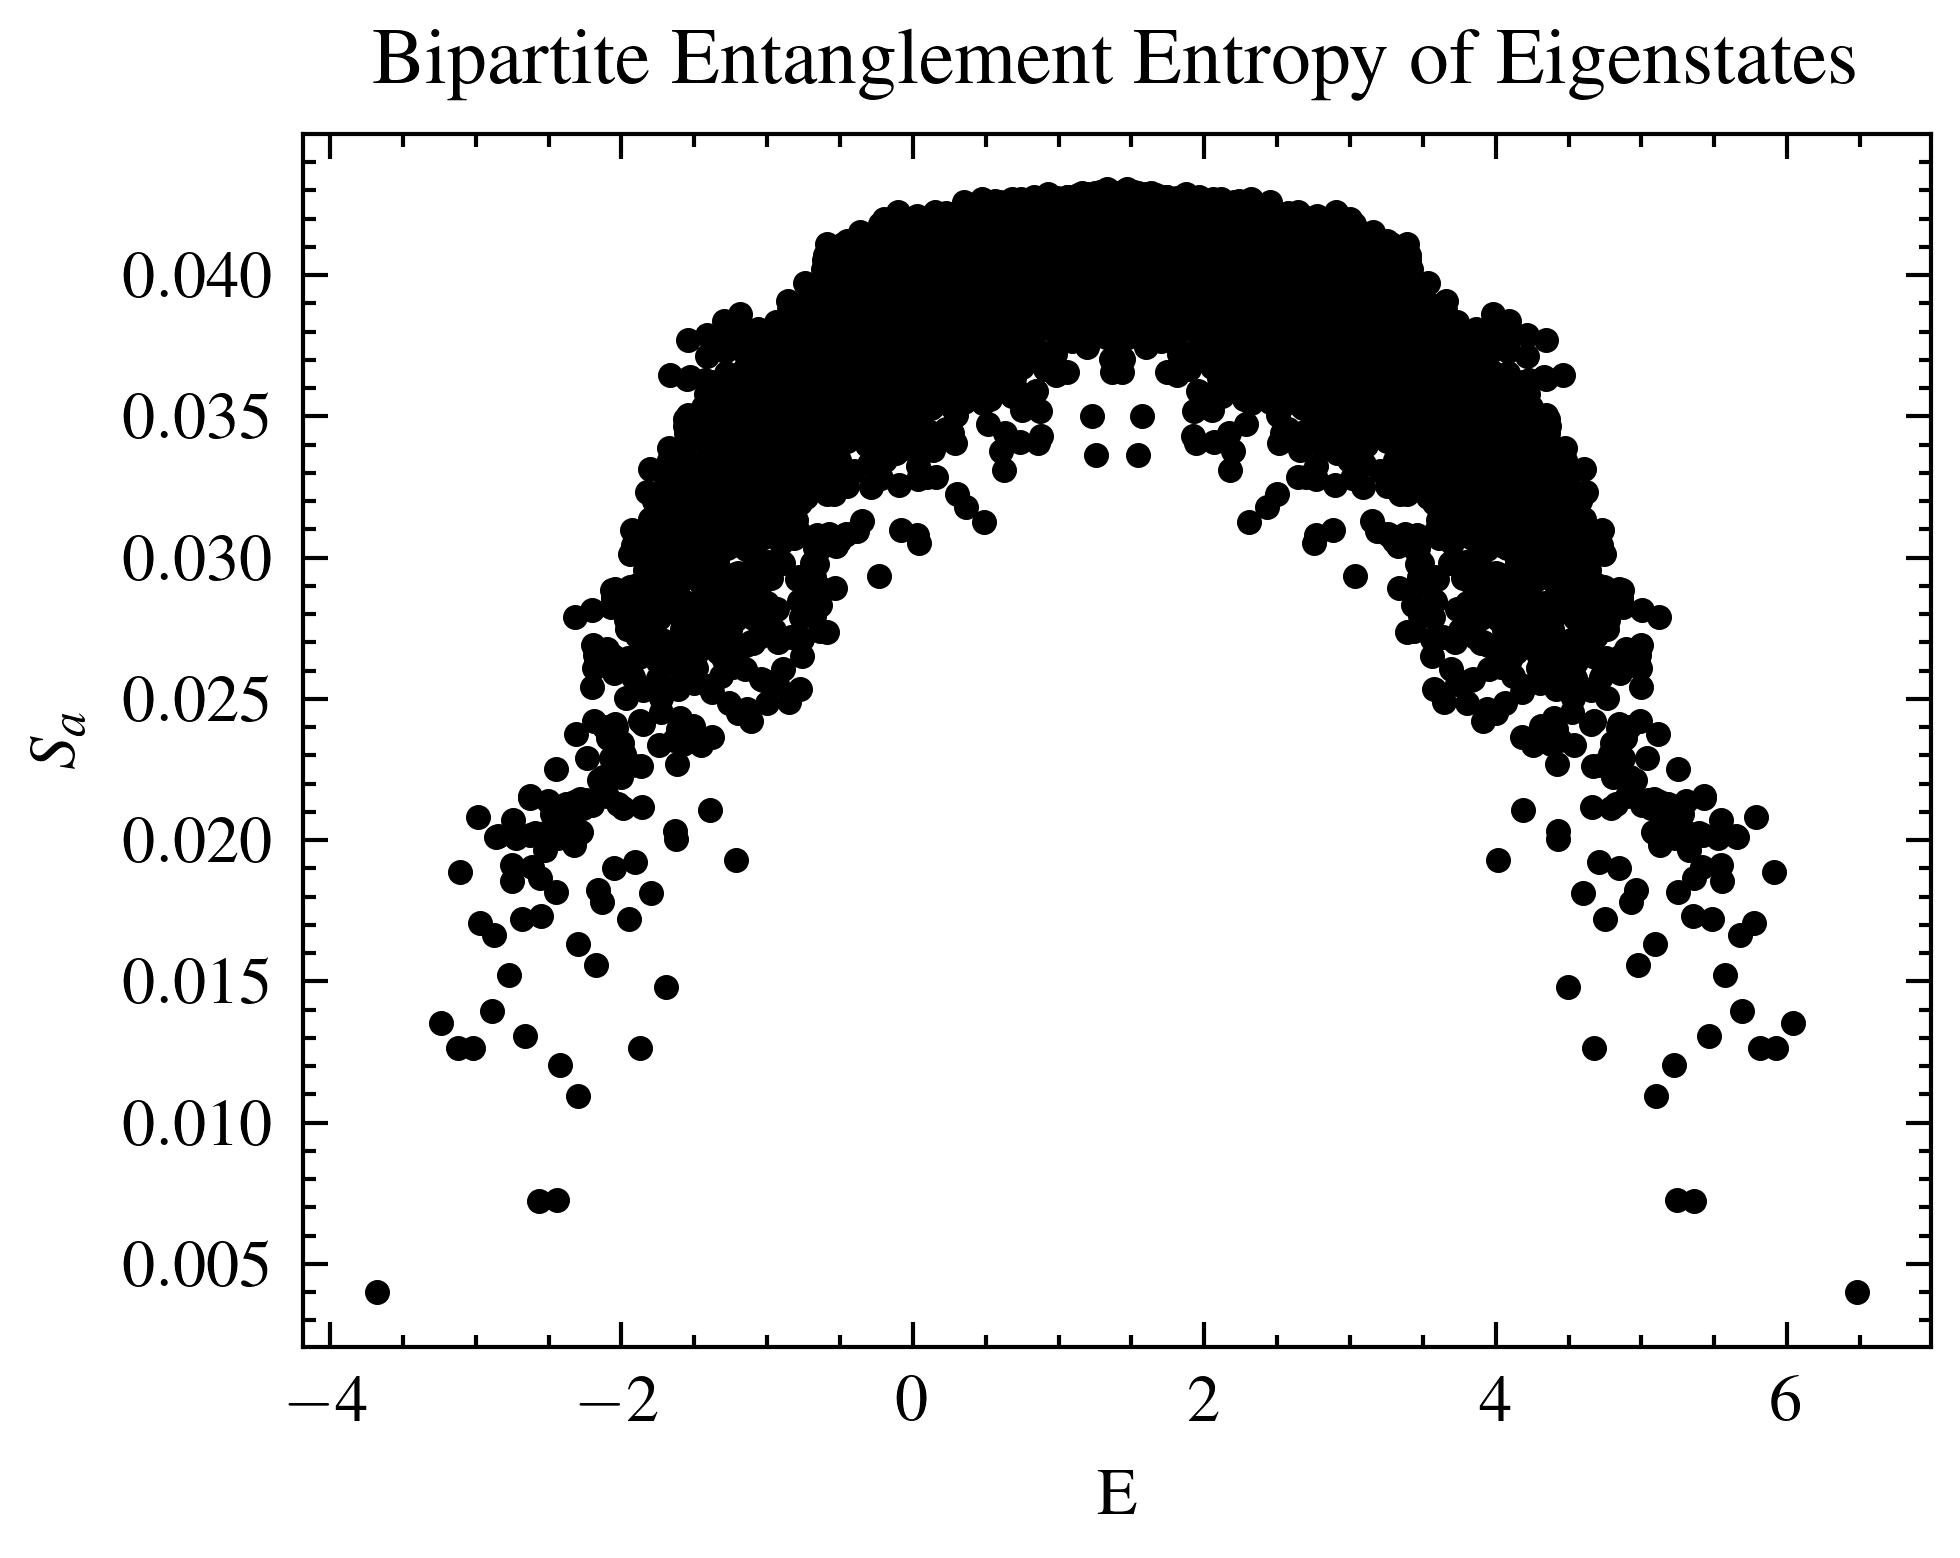

In [113]:
with plt.style.context(['science', 'scatter']):
    plt.title('Bipartite Entanglement Entropy of Eigenstates')
    plt.scatter(eigenvalues/L,eigen_entropies,s=4,color='black')
    plt.xlabel('E')
    plt.ylabel(r'$S_a$')
